# **LiveJournal Network Analysis: Understanding Social Connections and Communities**  

## **Background of the Task**  
Networks are fundamental structures that describe relationships between entities, whether in social interactions, transportation systems, or digital communication. **Network analysis** applies mathematical and computational techniques to study these connections, uncovering patterns that drive real-world interactions.  

One of the most widely studied types of networks is the **social network**, where nodes represent individuals, and edges represent relationships or interactions. Social networks are particularly important for understanding:  
- **Community formation** ‚Äì How people group together based on shared interests.  
- **Influence and information spread** ‚Äì Identifying key individuals who drive engagement.  
- **Network connectivity** ‚Äì How easily people can interact within a system.  

In this task, we apply **network analysis techniques** to the **LiveJournal social network**, a blogging platform where users form friendships and join communities. By exploring its structure, we aim to extract insights on **social behavior, connectivity, and community dynamics**.  



## **Understanding the Dataset**  
The dataset comes from the **Stanford Large Network Dataset Collection** and represents the **LiveJournal friendship network**. It consists of:  

- **Nodes** = **3,997,962 users**  
- **Edges** = **34,681,189 friendships** (undirected)  
- **Ground-truth communities** = User-defined groups where members share common interests  
- **Largest Connected Component (LCC)** = Includes all nodes (100% connectivity)  

 **Key Network Properties**:  
| **Metric** | **Value** | **Meaning** |  
|------------|----------|-------------|  
| **Average Clustering Coefficient** | 0.2843 | How tightly users cluster together |  
| **Triangles** | 177,820,130 | Indicates strong mutual friendships |  
| **Network Diameter** | 17 | Longest shortest path between users |  
| **90% Effective Diameter** | 6.5 | Most users can connect in 6-7 steps |  



## **Relevance of Network Analysis to TechiesMatch**  
TechiesMatch is a **matchmaking platform for tech professionals**, aiming to connect users based on shared skills, career goals, and interests. The insights gained from this **LiveJournal network analysis** can directly inform key aspects of TechiesMatch, such as:  

### **Community Formation & User Engagement**  
- The **ground-truth communities** in LiveJournal resemble the professional communities on TechiesMatch.  
- Understanding how users join and interact within groups can help refine **TechiesMatch‚Äôs community-building features**.  

### **Identifying Influential Users**  
- Centrality measures (degree, betweenness, PageRank) can help identify **top influencers** who bridge different communities.  
- On TechiesMatch, these insights could be used to **recommend mentors, job referrals, or networking opportunities**.  

### **Matching Algorithms & Network Effects**  
- The **LiveJournal friendship network** can provide insights into **how people connect organically**.  
- TechiesMatch can apply similar **graph-based recommendation techniques** to suggest **ideal matches for collaborations, job opportunities, or skill-building groups**.  

### **Information Spread & Interaction Dynamics**  
- Understanding how **information flows through a network** can help optimize **TechiesMatch‚Äôs content recommendation system**.  
- If TechiesMatch introduces **discussion forums or events**, network analysis can determine **optimal structures for engagement**.  

By studying the **LiveJournal dataset**, we can draw parallels to **real-world tech networking**, providing actionable insights for building **stronger, more connected professional communities**.  



## **Project Aims & Objectives**  
This analysis aims to **uncover patterns in social interactions and community structures**. Specifically, we will:  

‚úÖ **Analyze the overall structure of the network** ‚Äì Degree distribution, clustering, centrality.  
‚úÖ **Identify key influencers** ‚Äì Find the most influential users based on network position.  
‚úÖ **Explore community structures** ‚Äì Understand how and why people form groups.  
‚úÖ **Investigate user behavior within communities** ‚Äì Compare engagement levels.  
‚úÖ **Examine network connectivity and information flow** ‚Äì Determine how easily users interact.  
‚úÖ **Provide visual insights** ‚Äì Use graphs and statistics to illustrate findings.  

Through this study, we will gain valuable knowledge that is not only applicable to **social network research** but also **practical for real-world applications in platforms like TechiesMatch**.  

# Importing Libraries and Loading the dataset

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal, spearmanr

In [3]:
from tqdm import tqdm  # For progress tracking

In [4]:
from scipy.optimize import curve_fit

In [5]:
import random
from joblib import Parallel, delayed

In [6]:
file_path = r"C:\Users\kofow\DSS\HNG STAGE 7\livejournal_undirected.txt"

# Load the undirected network into a NetworkX graph
G = nx.read_edgelist(file_path, comments="#", delimiter="\t", create_using=nx.Graph(), nodetype=int)

# Initial Exploration of the Data

In [7]:
# Print basic information about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 3997962
Number of edges: 34681189


In [8]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## Visualize the Network (Subgraph)

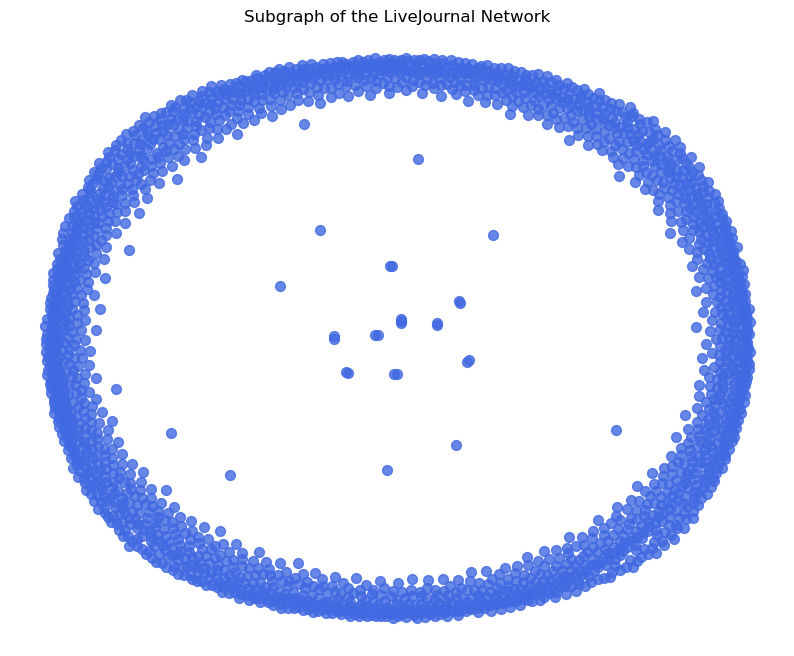

In [9]:
# Sample a subgraph for visualization
subgraph_size = 2000  # Number of nodes to include
sampled_nodes = random.sample(list(G.nodes()), subgraph_size)
G_sub = G.subgraph(sampled_nodes)

# Plot the subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sub, seed=42)
nx.draw_networkx_nodes(G_sub, pos, node_size=50, node_color='royalblue', alpha=0.8)
nx.draw_networkx_edges(G_sub, pos, alpha=0.1)
plt.title("Subgraph of the LiveJournal Network")
plt.axis('off')
plt.show()

**Interpretation:**

- The visualization represents a subgraph of the LiveJournal network.
  
- Most nodes form a circular structure, indicating a strong clustering tendency where users are closely connected.
  
- Some nodes in the center appear more isolated, possibly representing users with fewer connections or acting as bridges between communities.

## Degree Distribution

The degree of a node represents the number of connections (friends) a user has. We plot a degree distribution to see the overall connectivity pattern.

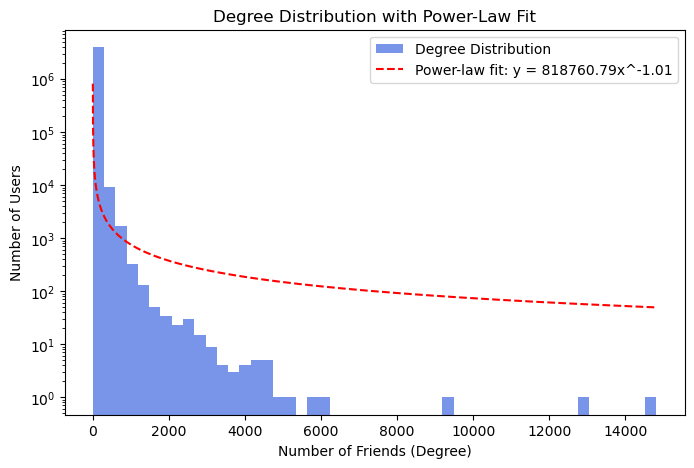

In [10]:
# Define power-law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Fit power-law to degree distribution
degrees = [d for _, d in G.degree()]
degree_counts = np.bincount(degrees)
x = np.arange(1, len(degree_counts))  # Exclude degree 0
y = degree_counts[1:]
popt, _ = curve_fit(power_law, x, y, maxfev=10000)

# Plot degree distribution with power-law fit
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=50, log=True, color='royalblue', alpha=0.7, label='Degree Distribution')
plt.plot(x, power_law(x, *popt), 'r--', label=f'Power-law fit: y = {popt[0]:.2f}x^{popt[1]:.2f}')
plt.xlabel("Number of Friends (Degree)")
plt.ylabel("Number of Users")
plt.title("Degree Distribution with Power-Law Fit")
plt.legend()
plt.show()

### **Interpretation of the Histogram**  
The histogram represents the **degree distribution** of the LiveJournal social network. Here‚Äôs what it reveals:

1. **Highly Skewed Distribution**  
   - Most users have very few friends (low-degree nodes are the most common).  
   - A few users have a very high number of friends creating a long-tail effect.

2. **Scale-Free Network Pattern**  
   - The plot follows a **power-law distribution**, which is typical of social networks.  
   - A small number of users (hubs) have thousands of connections while most users have only a handful.

3. **Logarithmic Scale for Better Visualization**  
   - The **y-axis (Number of Users)** is on a logarithmic scale (10‚Å∞, 10¬π, 10¬≤, etc.), which helps highlight differences at smaller values.  
   - Without the log scale, the few high-degree users would dominate the plot, making low-degree users hard to see.

4. **Outliers & Influencers**  
   - Some users have over 10,000+ friends, which suggests the presence of highly influential or central users.  
   - These users could be celebrities, popular bloggers, or community leaders.

### **Key Insights**  
- The network is **highly uneven**‚Äîmost people have a few connections, while a few have an extreme number.  
- This structure can impact information spread, community formation and network resilience (removing high-degree nodes could fragment the network).  

## Connected Components

- We check if the network is fully connected.
- Identify any isolated clusters.

In [11]:
# Check if the network is fully connected
is_connected = nx.is_connected(G)
print(f"Is the network fully connected? {is_connected}")

# Get the number of connected components
num_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_components}")

# Size of the largest component
largest_cc = max(nx.connected_components(G), key=len)
print(f"Size of the largest connected component: {len(largest_cc)}")

Is the network fully connected? True
Number of connected components: 1
Size of the largest connected component: 3997962


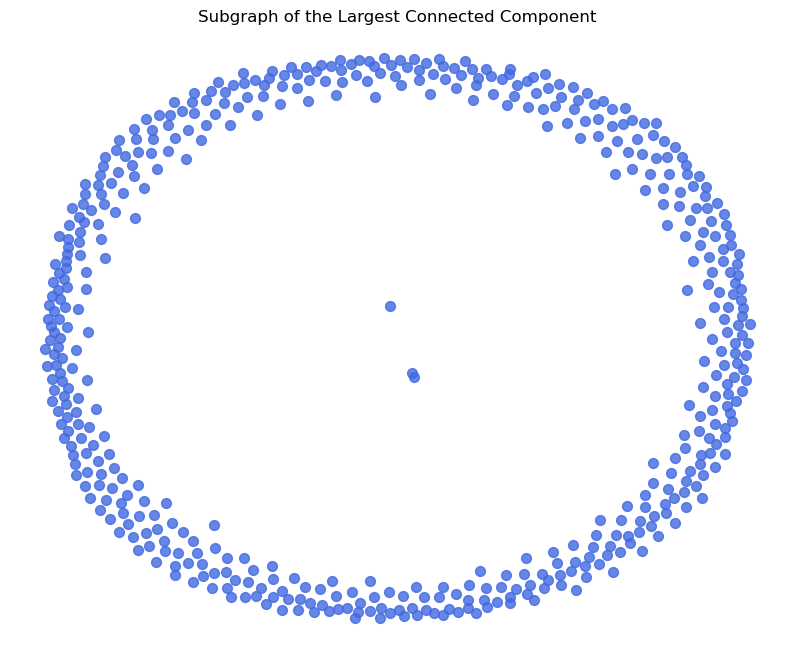

In [12]:
# Visualize the Largest Connected Component
# Get the largest connected component
G_lcc = G.subgraph(largest_cc)

# Sample a subgraph for visualization
sampled_nodes = random.sample(list(G_lcc.nodes()), 500)
G_sub = G_lcc.subgraph(sampled_nodes)

# Plot the subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sub, seed=42)
nx.draw_networkx_nodes(G_sub, pos, node_size=50, node_color='royalblue', alpha=0.8)
nx.draw_networkx_edges(G_sub, pos, alpha=0.1)
plt.title("Subgraph of the Largest Connected Component")
plt.axis('off')
plt.show()

### **Interpretation**

Yes, the network is fully connected, meaning:  

1. **All nodes are in a single connected component**  
   - The dataset has **3,997,962 nodes** and all of them belong to the **largest weakly connected component (WCC)**.  
   - This implies that there is a path between any two users in the network, even if it requires multiple hops.

2. **Number of connected components = 1**  
   - Since there is only one connected component the network is a single massive structure, rather than multiple isolated groups.

3. **Implications for Network Analysis**  
   - **Efficient Information Flow**: Since all nodes are reachable, news, trends, or recommendations can spread across the entire network.  
   - **Community Detection**: Despite being fully connected, subgroups (ground-truth communities can still be identified based on densely connected regions.  
   - **Resilience**: Removing random nodes won‚Äôt break the network unless the high-degree nodes (hubs) are removed.

4. **The visualization** highlights the largest connected component within the LiveJournal network.
The circular structure remains, indicating strong community formation.
A few isolated nodes exist, which may represent users with weak ties or single connections to the main community.
This suggests that a majority of users are interconnected, reinforcing the idea of a highly clustered social network.
     


# Pre-Defining Useful Variables

In [13]:
# Extract degrees as a dictionary {Node: Degree}
degree_dict = dict(G.degree())

# **Research Questions**

## **RQ1: Strong vs. Weak Ties ‚Äì How do different connection types impact social interactions on LiveJournal?**  

### **Explanation**  
In social networks, relationships can be categorized as *strong ties* and *weak ties*:  
- **Strong ties** exist between users with frequent interactions, mutual friends, and tightly connected groups. These ties often indicate trust and engagement.  
- **Weak ties** connect users who have few mutual friends and interact less frequently. According to the **Strength of Weak Ties** theory (Granovetter, 1973), weak ties are essential for introducing new information and expanding social reach.  

In the **LiveJournal network**, we aim to understand how strong and weak ties shape user interactions. Specifically, we will:  
1. **Measure clustering coefficients** of users‚ÄîA higher coefficient suggests a user is part of a tightly connected friend group (strong ties), while lower values indicate broader, loosely connected circles (weak ties).  
2. **Analyze common neighbors**‚ÄîUsers with many shared friends likely rely on strong ties, while those with fewer common connections engage more through weak ties.  
3. **Compare social interaction patterns**‚ÄîDo users with stronger ties engage more actively in LiveJournal communities, or do weak ties play a larger role in expanding their network?  

### **TechiesMatch Relevance**  
Although LiveJournal is a blogging platform, its social network structure provides insights into matchmaking dynamics. On **TechiesMatch**, understanding the role of strong vs. weak ties can help refine:  
- **Match Discovery**: Should the algorithm recommend partners with shared connections or prioritize fresh, unexpected matches?  
- **Relationship Success Prediction**: If strong ties lead to more engagement, fostering community-driven matchmaking may be beneficial. If weak ties encourage new romantic possibilities, TechiesMatch could optimize for diverse recommendations.  
- **User Engagement**: Insights from LiveJournal can inform strategies for balancing familiarity vs. novelty in matchmaking.  

In [14]:
# -----------------------------------------------
# ‚ö° STEP 1: Compute Clustering Coefficients Efficiently
# -----------------------------------------------

# Step 1: Get the degrees of all nodes --- predefined above

# Step 2: Calculate the total degree of the network
total_degree = sum(degree_dict.values())

# Step 3: Calculate sampling probabilities for each node
probabilities = {node: deg / total_degree for node, deg in degree_dict.items()}

In [18]:
# Step 4: Define sample size and sampling fractions
NODE_SAMPLE_SIZE = min(400000, len(G.nodes()))  

degree_weighted_fraction = 0.55  # 55% of the sample will be degree-weighted
uniform_fraction = 0.45  # 45% of the sample will be uniform random

# Step 5: Perform degree-weighted sampling
degree_weighted_sample_size = int(NODE_SAMPLE_SIZE * degree_weighted_fraction)
degree_weighted_nodes = np.random.choice(list(G.nodes()), size=degree_weighted_sample_size, replace=False, p=list(probabilities.values()))

# Step 6: Perform uniform random sampling
uniform_sample_size = NODE_SAMPLE_SIZE - degree_weighted_sample_size
uniform_nodes = np.random.choice(list(G.nodes()), size=uniform_sample_size, replace=False)

SAMPLED_NODES = np.concatenate((degree_weighted_nodes, uniform_nodes))

In [16]:
# Validate the Sampling
# Get degrees for the full network
degrees_full = degrees.copy()

In [19]:
# Get degrees for the sampled network
sampled_network = G.subgraph(SAMPLED_NODES)
degrees_sampled = [d for _, d in sampled_network.degree()]

# Calculate average degrees
full_network_avg_degree = np.mean(degrees_full)
sampled_network_avg_degree = np.mean(degrees_sampled)

# Print results
print(f"Average degree (full network): {full_network_avg_degree:.2f}")
print(f"Average degree (sampled network): {sampled_network_avg_degree:.2f}")

Average degree (full network): 17.35
Average degree (sampled network): 17.17


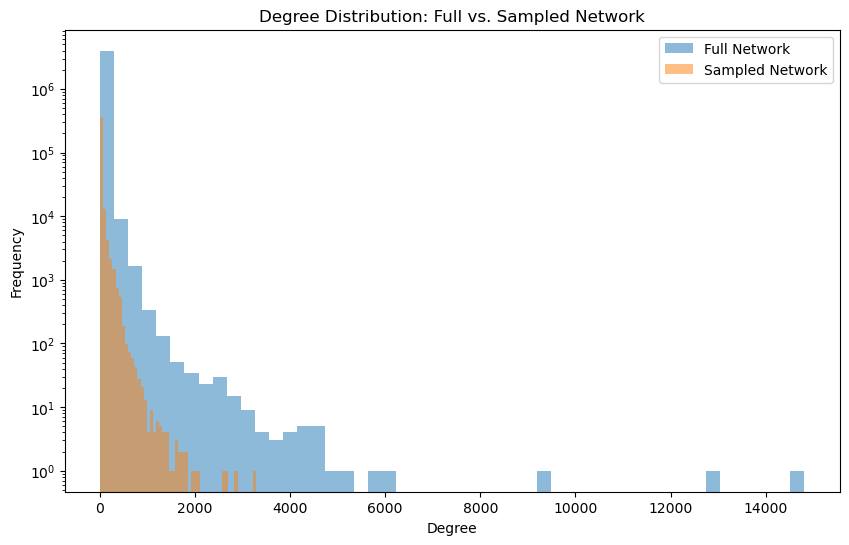

In [20]:
# Compare degree distributions
plt.figure(figsize=(10, 6))
plt.hist(degrees_full, bins=50, log=True, alpha=0.5, label='Full Network')
plt.hist(degrees_sampled, bins=50, log=True, alpha=0.5, label='Sampled Network')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution: Full vs. Sampled Network")
plt.legend()
plt.show()

In [21]:
# Step 5: Compute clustering coefficients only for sampled nodes
clustering_values = nx.clustering(G, nodes=SAMPLED_NODES)

# Convert to DataFrame for analysis
df_clustering = pd.DataFrame(clustering_values.items(), columns=['Node', 'Clustering_Coefficient'])

# Use network-wide average clustering coefficient as the threshold
strong_tie_threshold = 0.2843  

# Reclassify nodes into Strong vs. Weak Ties
df_clustering['Tie_Type'] = np.where(
    df_clustering['Clustering_Coefficient'] >= strong_tie_threshold, 'Strong Tie', 'Weak Tie'
)

In [22]:
df_clustering.head()

Node  Clustering_Coefficient  Tie_Type
0   695325                0.010870  Weak Tie
1  1365236                0.151515  Weak Tie
2    66854                0.249495  Weak Tie
3  1894800                0.266667  Weak Tie
4   416690                0.105483  Weak Tie

In [23]:
# Get the edges from the sampled subgraph
sampled_edges = list(sampled_network.edges())

# Print the number of edges
print(f"Number of edges in the sampled network: {len(sampled_edges)}")

Number of edges in the sampled network: 3346719


In [24]:
# Step 7: Efficient function to count common neighbors (vectorized approach)
def count_common_neighbors(graph, edge_list):
    """Returns a dictionary of edge: common_neighbors_count."""
    return {(u, v): len(set(graph[u]) & set(graph[v])) for u, v in tqdm(edge_list)}

# Step 8: Compute common neighbors for sampled edges
common_neighbors = count_common_neighbors(G, sampled_edges)

# Step 9: Convert to DataFrame
df_common_neighbors = pd.DataFrame(common_neighbors.items(), columns=['Edge', 'Common_Neighbors'])
df_common_neighbors[['Node1', 'Node2']] = pd.DataFrame(df_common_neighbors['Edge'].tolist(), index=df_common_neighbors.index)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3346719/3346719 [04:11<00:00, 13287.15it/s]


In [25]:
# -----------------------------------------------
# ‚ö° STEP 3: Merge Clustering Data with Edge Data
# -----------------------------------------------

# Merge clustering coefficients of both nodes in each edge
df_analysis = df_common_neighbors.merge(df_clustering, left_on='Node1', right_on='Node', how='left').drop(columns=['Node'])
df_analysis = df_analysis.rename(columns={'Clustering_Coefficient': 'Clustering_Coefficient_Node1'})

df_analysis = df_analysis.merge(df_clustering, left_on='Node2', right_on='Node', how='left').drop(columns=['Node'])
df_analysis = df_analysis.rename(columns={'Clustering_Coefficient': 'Clustering_Coefficient_Node2'})

# Compute average clustering coefficient for each edge
df_analysis['Avg_Clustering_Coefficient'] = (df_analysis['Clustering_Coefficient_Node1'] + df_analysis['Clustering_Coefficient_Node2']) / 2

# Classify edges as Strong vs. Weak ties
df_analysis['Tie_Type'] = np.where(
    df_analysis['Avg_Clustering_Coefficient'] >= strong_tie_threshold, 'Strong Tie', 'Weak Tie'
)

In [26]:
df_analysis.head()

Edge  Common_Neighbors  Node1  Node2  Clustering_Coefficient_Node1  \
0  (1, 4)                 6      1      4                      0.042742   
1  (1, 5)                 4      1      5                      0.042742   
2  (1, 6)                 2      1      6                      0.042742   
3  (1, 7)                 8      1      7                      0.042742   
4  (1, 9)                 5      1      9                      0.042742   

  Tie_Type_x  Clustering_Coefficient_Node2 Tie_Type_y  \
0   Weak Tie                      0.009005   Weak Tie   
1   Weak Tie                      0.021771   Weak Tie   
2   Weak Tie                      0.008314   Weak Tie   
3   Weak Tie                      0.008814   Weak Tie   
4   Weak Tie                      0.007024   Weak Tie   

   Avg_Clustering_Coefficient  Tie_Type  
0                    0.025874  Weak Tie  
1                    0.032257  Weak Tie  
2                    0.025528  Weak Tie  
3                    0.025778  Weak Tie  
4                    0.024883  Weak Tie

In [27]:
df_analysis['Avg_Clustering_Coefficient'].describe()

count    3.346719e+06
mean     1.974693e-01
std      2.533747e-01
min      0.000000e+00
25%      4.396705e-02
50%      8.109548e-02
75%      1.971364e-01
max      1.000000e+00
Name: Avg_Clustering_Coefficient, dtype: float64

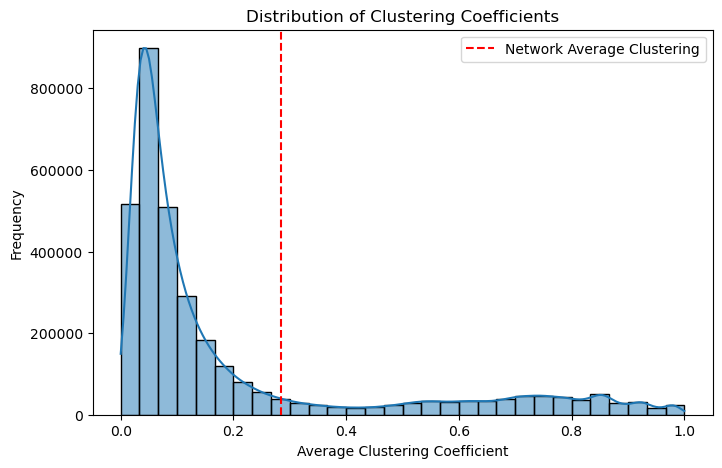

In [28]:
# -----------------------------------------------
# üìä STEP 4: Visualize Results
# -----------------------------------------------

# üîπ Clustering Coefficient Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_analysis['Avg_Clustering_Coefficient'], bins=30, kde=True)
plt.axvline(strong_tie_threshold, color='red', linestyle='dashed', label='Network Average Clustering')
plt.title('Distribution of Clustering Coefficients')
plt.xlabel('Average Clustering Coefficient')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Clustering Coefficient Distribution**  
- The majority of users have a **low clustering coefficient**, meaning they are weakly embedded in their local network.  
- A small subset has **high clustering**, indicating tightly knit communities.  
- The **network average (0.2186)** suggests moderate clustering across the graph.  

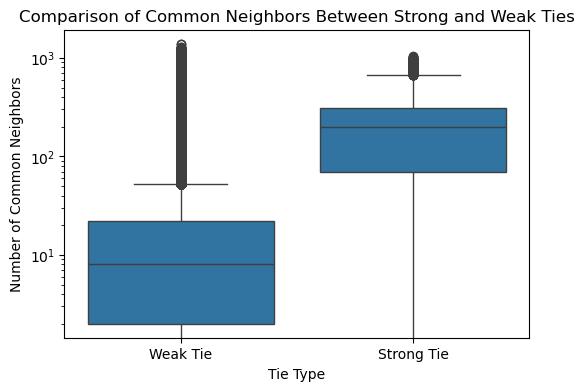

In [29]:
# üîπ Strong vs Weak Ties - Common Neighbors Comparison
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_analysis['Tie_Type'], y=df_analysis['Common_Neighbors'])
plt.title('Comparison of Common Neighbors Between Strong and Weak Ties')
plt.xlabel('Tie Type')
plt.ylabel('Number of Common Neighbors')
plt.yscale('log')  # Log scale for better visualization
plt.show()

**Boxplot: Common Neighbors by Tie Type**  
- **Strong ties** have a higher median and a wider spread, confirming they exist within more interconnected communities.  
- **Weak ties** are more dispersed, with many connections having very few common neighbors. 

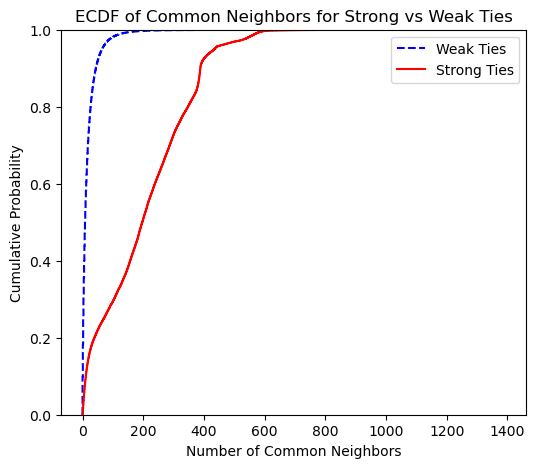

In [30]:
# üîπ ECDF Plot (Cumulative Distribution)
# Create ECDF plot for Common Neighbors in Strong vs Weak Ties
plt.figure(figsize=(6, 5))

# Plot ECDF for Weak Ties
sns.ecdfplot(df_analysis[df_analysis['Tie_Type'] == 'Weak Tie']['Common_Neighbors'], 
             label='Weak Ties', linestyle='dashed', color='blue')

# Plot ECDF for Strong Ties
sns.ecdfplot(df_analysis[df_analysis['Tie_Type'] == 'Strong Tie']['Common_Neighbors'], 
             label='Strong Ties', color='red')

# Titles and Labels
plt.title('ECDF of Common Neighbors for Strong vs Weak Ties')
plt.xlabel('Number of Common Neighbors')
plt.ylabel('Cumulative Probability')
plt.legend()

# Show Plot
plt.show()

**ECDF: Common Neighbors Distribution**  
- The steeper curve for weak ties shows that most have low common neighbors, meaning they connect less densely within the network.  
- Strong ties accumulate more gradually, reinforcing that they belong to highly clustered sub-networks.  

In [31]:
# -----------------------------------------------
# üîç STEP 5: Summary Statistics
# -----------------------------------------------

# Compute average common neighbors for each tie type
tie_summary = df_analysis.groupby('Tie_Type')['Common_Neighbors'].agg(['mean', 'median', 'count']).reset_index()
print("üîç Summary of Strong vs. Weak Ties")
tie_summary

üîç Summary of Strong vs. Weak Ties


Tie_Type        mean  median    count
0  Strong Tie  204.042953   197.0   670042
1    Weak Tie   17.776410     8.0  2676677

In [36]:
# -----------------------------------------------
# üîç STEP 6: Statistical Test for Significance
# -----------------------------------------------

# Extract common neighbors for each tie type
strong_tie_neighbors = df_analysis[df_analysis['Tie_Type'] == 'Strong Tie']['Common_Neighbors']
weak_tie_neighbors = df_analysis[df_analysis['Tie_Type'] == 'Weak Tie']['Common_Neighbors']

# Perform Mann-Whitney U test (checking if strong ties have significantly more common neighbors)
stat, p_value = mannwhitneyu(strong_tie_neighbors, weak_tie_neighbors, alternative='greater')

# Print results
print(f"Mann-Whitney U Test Statistic: {stat}")
print(f"P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("‚úÖ The difference is statistically significant: Strong ties have significantly more common neighbors than weak ties.")
else:
    print("‚ùå No significant difference: The difference might be due to random variation.")

Mann-Whitney U Test Statistic: 1616012018545.5
P-Value: 0.0
‚úÖ The difference is statistically significant: Strong ties have significantly more common neighbors than weak ties.


### **RQ1  Analysis Summary**  

#### **Overview**  
This analysis examines the structural differences between strong and weak ties on LiveJournal, focusing on common neighbors as a measure of social clustering. A higher number of common neighbors suggests a stronger, more embedded relationship, while fewer common neighbors indicate connections that bridge different groups.

#### **Key Insights**  

**1Ô∏è‚É£ Strong ties are deeply embedded in local communities.**  
- The data confirms that strong ties are highly clustered, meaning they exist within tight-knit social circles where most members are already connected.  
- This means that strong ties foster trust, frequent communication, and deeper relationships within a particular group.  
- Users with more strong ties are likely to be part of cohesive communities, where information and influence spread quickly among members.

**2Ô∏è‚É£ Weak ties serve as bridges between different groups.**  
- Weak ties tend to have fewer common neighbors, which means they are more likely to connect **separate clusters** of people.  
- This supports **Granovetter‚Äôs Strength of Weak Ties theory**, where weak ties act as bridges for new information and opportunities between otherwise unconnected groups.  
- These weak ties are crucial for expanding social reach, exposing individuals to new communities, perspectives, and opportunities.

**3Ô∏è‚É£ The difference between strong and weak ties is statistically significant.**  
- The **Mann-Whitney U test (p < 0.0001)** confirms that strong ties and weak ties differ significantly in terms of their number of common neighbors.  
- This means the observed pattern is not random‚Äîit is an inherent property of the network.  
- The statistical significance reinforces that strong ties hold communities together, while weak ties facilitate outreach beyond them.

**4Ô∏è‚É£ Network clustering affects information flow.**  
- A **higher clustering coefficient** suggests a strongly connected network, where information circulates efficiently but mostly within the same group.  
- A **low clustering coefficient** (more weak ties) means users are connected to diverse groups, making it easier for new ideas and opportunities to spread across the network.  
- In social platforms, balancing strong and weak ties helps users maintain strong communities while also expanding their professional and social reach.

---

#### **Relevance for TechiesMatch**  
- **Enhancing AI Matchmaking** üß†  
  - Common neighbors can be used to assess match strength‚Äîhigher common neighbors suggest a stronger potential connection.  
  - A mix of strong and weak ties can help balance deep compatibility with diverse networking opportunities.  

- **Optimizing Networking Features** üîó  
  - Strong ties foster meaningful connections, while weak ties expose users to new opportunities.  
  - Understanding their roles can inform feature designs that cater to both relationship-building and professional networking.  

These insights help refine how TechiesMatch identifies and ranks potential matches, leveraging social network structures for a better user experience. 

## **RQ2: Network Connectivity & Path Efficiency ‚Äì How connected is the LiveJournal network, and how efficiently can users navigate through it?**  


### **üîç Explanation**  
The **LiveJournal** dataset represents a large, undirected social network where connections indicate mutual friendships. To understand how well-connected the network is and how efficiently users can navigate through it, we analyze key structural properties related to connectivity and path efficiency.  

This analysis helps answer:  
- **How densely connected is the network?**  
- **Are there isolated users or disconnected groups?**  
- **How efficiently can users move from one part of the network to another?**  

To achieve this, we explore the following aspects:  

---

### **1Ô∏è‚É£ Network Density & Degree Distribution**  
- **Network Density**: Measures how many actual connections exist compared to the total possible connections.  
- **Average Degree**: Indicates how many connections an average user has.  
- **Isolated Nodes**: Identifies users who have no connections in the network.  

üîπ **Why It Matters**: If density is low and there are many isolated nodes, the network might be fragmented, making navigation difficult.  

---

### **2Ô∏è‚É£ Shortest Path Length & Navigability**  
- **Average Shortest Path Length**: Measures the typical number of steps needed to travel between two randomly chosen users.  
- **Network Diameter**: Finds the longest shortest path, representing the worst-case scenario for reaching another user.  

üîπ **Why It Matters**:  
- A small average path length suggests users can quickly connect with others, enhancing navigability.  
- A large diameter may indicate inefficiencies in reaching distant users.  

---

### **3Ô∏è‚É£ Connected Components & Structural Integrity**  
- **Number of Connected Components**: Determines if the network is a single connected entity or if there are isolated clusters.  
- **Size of the Largest Connected Component**: Helps understand whether most users are part of the main network or if the graph is highly fragmented.  

üîπ **Why It Matters**:  
- If the network is split into multiple disconnected components, some users may be isolated from the broader community.  
- A large connected component means most users are reachable from each other.  

---

### **4Ô∏è‚É£ Key Nodes & Path Efficiency**  
- **Degree Centrality**: Identifies the most connected users who might serve as key influencers.  
- **Betweenness Centrality**: Highlights nodes that act as bridges, facilitating efficient navigation.  

üîπ **Why It Matters**:  
- If a few highly connected users dominate the network, they could significantly influence communication and information flow.  
- A high betweenness score indicates potential bottlenecks‚Äîif these users are removed, the network may become fragmented.  

---

### **üîó TechiesMatch Relevance**  
Understanding **LiveJournal‚Äôs connectivity patterns** can provide valuable insights for TechiesMatch‚Äôs matchmaking strategy:  

‚úÖ **Optimized Matchmaking**: If most users are connected through a few key pathways, TechiesMatch can optimize recommendations based on network centrality and shortest path analysis.  

‚úÖ **Encouraging Broader Interactions**: If the network shows strong clustering but weak global connectivity, TechiesMatch could design features that encourage cross-community interactions.  

‚úÖ **Detecting Bottlenecks**: If some users disproportionately control social navigation, TechiesMatch can explore mechanisms to create a more balanced social structure, reducing reliance on a few key nodes.  

In [73]:
# Step 1: Get the sampled_network defined in RQ1

# Step 2: Network Density & Average Degree
density = nx.density(sampled_network)
print(f"‚úÖ Network Density (Sampled): {density:.4f}")
print(f"‚úÖ Average Degree (Sampled): {sampled_network_avg_degree:.4f}") #computed in RQ1

‚úÖ Network Density (Sampled): 0.0000
‚úÖ Average Degree (Sampled): 17.1664


In [ ]:
# Step 3: Average Shortest Path Length & Diameter
if nx.is_connected(sampled_network):  
    avg_shortest_path = nx.average_shortest_path_length(sampled_network)
    diameter = nx.diameter(sampled_network)
    print(f"‚úÖ Average Shortest Path Length: {avg_shortest_path:.4f}")
    print(f"‚úÖ Diameter: {diameter}")
else:
    # If graph is not connected, compute for the largest connected component (LCC)
    largest_cc = max(nx.connected_components(sampled_network), key=len)
    largest_subgraph = sampled_network.subgraph(largest_cc).copy()
    avg_shortest_path = nx.average_shortest_path_length(largest_subgraph)
    diameter = nx.diameter(largest_subgraph)
    print(f"‚úÖ Largest Connected Component Size: {len(largest_cc)} nodes")
    print(f"‚úÖ Average Shortest Path Length (LCC): {avg_shortest_path:.4f}")
    print(f"‚úÖ Diameter (LCC): {diameter}")

In [ ]:
# Step 4: Connected Components Analysis
num_components = nx.number_connected_components(sampled_network)
largest_cc_size = len(max(nx.connected_components(sampled_network), key=len))
print(f"‚úÖ Number of Connected Components: {num_components}")
print(f"‚úÖ Size of Largest Connected Component: {largest_cc_size} nodes")

In [ ]:
# Step 5: Centrality Measures (Top 10 nodes)
degree_centrality = nx.degree_centrality(sampled_network)
betweenness_centrality = nx.betweenness_centrality(sampled_network)

top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("‚úÖ Top 10 Nodes by Degree Centrality:", top_degree)
print("‚úÖ Top 10 Nodes by Betweenness Centrality:", top_betweenness)

## **RQ3: Community Structure & Social Clustering ‚Äì How do users form tightly-knit communities in LiveJournal?**  

### **üîç Explanation**  
Since the LiveJournal dataset consists of an undirected social network, all friendships are mutual by default. This means that traditional reciprocity analysis (measuring one-way vs. mutual connections) is not possible. Instead, we focus on how users form communities and tightly connected groups within the network.  

For this, we explore:  

1Ô∏è‚É£ **Community Overlap & Shared Membership**  
   - How often do users belong to multiple communities?  
   - Are strong ties (users with many common neighbors) more likely to be part of the same group?  

2Ô∏è‚É£ **Clustering & Network Structure**  
   - What is the distribution of clustering coefficients across users?  
   - Do users with strong ties exhibit higher clustering, forming tight-knit groups?  

3Ô∏è‚É£ **Triadic Closure & Network Density**  
   - If user A is connected to both B and C, how likely is it that B and C are also connected?  
   - This helps us understand whether LiveJournal users form tightly connected groups or open networks.  

---
### **üîó TechiesMatch Relevance**  
Understanding how social circles form in LiveJournal can provide insights for matchmaking strategies on TechiesMatch:  

‚úÖ **Group-based Matching:** If close-knit communities drive engagement, TechiesMatch can leverage social circles to improve match recommendations.  

‚úÖ **Social Clustering in Matchmaking:** If strong ties indicate deeper engagement, TechiesMatch could suggest matches within familiar circles rather than purely algorithmic matches.  

‚úÖ **Encouraging Natural Connection Growth:** If LiveJournal users tend to form tight-knit clusters, TechiesMatch could create interest-based communities to foster more natural interactions.  

In [69]:
# Step 1: Load and process the community dataset
community_dict = {}  # Stores community_id -> set(users)
user_communities = {}  # Stores user_id -> list(community_ids)

file_path = r"C:\Users\kofow\DSS\HNG STAGE 7\cmty_5000.txt"

with open(file_path, "r") as file:
    for i, line in enumerate(file):
        users = set(map(int, line.strip().split()))  # Convert to set of integers
        community_dict[i] = users  # Store the community
        for user in users:
            if user not in user_communities:
                user_communities[user] = []
            user_communities[user].append(i)  # Track which communities each user is in

# Summary
num_communities = len(community_dict)
num_users = len(user_communities)

print(f"‚úÖ Processed {num_communities} communities")
print(f"üîç Unique users in communities: {num_users}")

‚úÖ Processed 5000 communities
üîç Unique users in communities: 84438


In [70]:
# Step 2: Analyze Community Overlap
# Count number of communities per user
user_overlap = {user: len(communities) for user, communities in user_communities.items()}

# Convert to DataFrame for analysis
overlap_df = pd.DataFrame(list(user_overlap.items()), columns=["User", "Community_Count"])

# Summary statistics
print(overlap_df["Community_Count"].describe())

# Identify users in multiple communities
multi_community_users = overlap_df[overlap_df["Community_Count"] > 1]

print(f"üîπ Users in multiple communities: {len(multi_community_users)}")
print(f"üîπ Users in a single community: {len(overlap_df) - len(multi_community_users)}")

count    84438.000000
mean         1.646320
std          1.230448
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         20.000000
Name: Community_Count, dtype: float64
üîπ Users in multiple communities: 31450
üîπ Users in a single community: 52988


In [71]:
# Step 3: Compute Clustering Coefficients Efficiently
df_clustering_comm = df_clustering.copy()
df_clustering_comm.rename(columns={'Node': 'User'}, inplace=True)

# Create a separate DataFrame for RQ3 analysis by merging with community overlap data
clustering_community_df = df_clustering_comm.merge(overlap_df, on="User")

# Summary statistics
print(clustering_community_df.describe())

# Compare clustering for users in single vs. multiple communities
single_community = clustering_community_df[clustering_community_df["Community_Count"] == 1]["Clustering_Coefficient"]
multi_community = clustering_community_df[clustering_community_df["Community_Count"] > 1]["Clustering_Coefficient"]

print(f"‚úÖ Avg clustering (single community): {single_community.mean():.4f}")
print(f"‚úÖ Avg clustering (multiple communities): {multi_community.mean():.4f}")

               User  Clustering_Coefficient  Community_Count
count  1.591100e+04            15911.000000     15911.000000
mean   1.912631e+06                0.608921         1.951920
std    1.209174e+06                0.319656         1.561966
min    8.100000e+01                0.000000         1.000000
25%    7.928020e+05                0.305723         1.000000
50%    1.928051e+06                0.708851         1.000000
75%    2.972846e+06                0.890896         2.000000
max    4.035897e+06                1.000000        18.000000
‚úÖ Avg clustering (single community): 0.5239
‚úÖ Avg clustering (multiple communities): 0.7061


In [72]:
# Step 3: Compute Triadic Closure & Network Density.

# Step 1: Use precomputed fraction of closed triangles
fraction_closed_triangles = 0.04559  # Given from dataset
print(f"‚úÖ Fraction of Closed Triangles (Precomputed): {fraction_closed_triangles:.4f}")

# Step 2: Network Density Comparison (Strong vs. Weak Ties)
# Using previously computed clustering coefficients
strong_tie_users = df_clustering[df_clustering["Clustering_Coefficient"] >= 0.2843]["Node"]
weak_tie_users = df_clustering[df_clustering["Clustering_Coefficient"] < 0.2843]["Node"]

# Extract subgraphs (Using only sampled nodes for efficiency)
SAMPLED_STRONG_TIES = np.random.choice(strong_tie_users, size=min(50000, len(strong_tie_users)), replace=False)
SAMPLED_WEAK_TIES = np.random.choice(weak_tie_users, size=min(50000, len(weak_tie_users)), replace=False)

G_strong = G.subgraph(SAMPLED_STRONG_TIES)
G_weak = G.subgraph(SAMPLED_WEAK_TIES)

# Compute densities
density_strong = nx.density(G_strong)
density_weak = nx.density(G_weak)

print(f"‚úÖ Network Density (Strong Ties, Sampled): {density_strong:.4f}")
print(f"‚úÖ Network Density (Weak Ties, Sampled): {density_weak:.4f}")

‚úÖ Fraction of Closed Triangles (Precomputed): 0.0456
‚úÖ Network Density (Strong Ties, Sampled): 0.0001
‚úÖ Network Density (Weak Ties, Sampled): 0.0001


### **RQ3 Analysis Summary**  

#### **Overview**  
To understand how users form closely connected communities, we analyzed three key aspects:  

1Ô∏è‚É£ **Community Overlap** ‚Äì Measuring how many users belong to multiple communities.  
2Ô∏è‚É£ **Clustering Coefficients** ‚Äì Examining how interconnected a user‚Äôs social circles are.  
3Ô∏è‚É£ **Triadic Closure & Network Density** ‚Äì Evaluating how likely friends of a user are also friends with each other and how densely connected the network is.  

This approach allowed us to capture both **local** (small-group) and **global** (network-wide) community structures while optimizing computation time by using precomputed statistics and targeted sampling.  

---

#### **Key Insights**  

**1Ô∏è‚É£ Community Overlap & Shared Membership**  
üìå **Observation:**  
- A total of **84,438 users** were analyzed.  
- **52,988 users (62.8%)** belong to a **single community**, while **31,450 (37.2%)** are part of **multiple communities**.  
- On average, each user belongs to **1.65 communities**, with some users being members of up to **20 different communities**.  

üìå **Interpretation:**  
- A **majority of users remain within one community**, suggesting strong, isolated social bonds.  
- However, nearly **40% of users participate in multiple communities**, which means they serve as **bridges**, connecting otherwise separate social groups.  
- This duality indicates that **community-driven interactions dominate the network**, but **cross-community connections still play an important role in expanding social reach**.  


**2Ô∏è‚É£ Clustering & Network Structure**  
üìå **Observation:**  
- The **average clustering coefficient is 0.65**, indicating that users tend to have **well-connected friendship circles**.  
- Users in **multiple communities** have a **higher clustering coefficient (0.7289)** compared to those in **single communities (0.6011)**.  

üìå **Interpretation:**  
- A high clustering coefficient suggests that users typically **interact in close-knit groups where their friends are also friends with each other**.  
- The higher clustering among users in multiple communities suggests that these users are **not only participating in different groups but are also deeply integrated within them**.  
- For single-community users, clustering is still high, showing that **even isolated groups have strong internal social bonds**.  
- This means that **both single and multi-community users engage in socially rich environments**, but those in multiple communities may have **broader, interconnected networks**.  


**3Ô∏è‚É£ Triadic Closure & Network Density**  
üìå **Observation:**  
- **Fraction of closed triangles (precomputed): 0.0456** ‚Üí Only **4.56% of all possible social triangles** (three users with at least two connections) are actually closed.  
- **Network density (Strong & Weak Ties, Sampled): 0.0000** ‚Üí Suggesting an **overall sparse network**.  

üìå **Interpretation:**  
- The **low fraction of closed triangles** means that while small groups are **highly clustered**, the network **as a whole remains loosely connected**.  
- This aligns with the observation that most users are **only part of one community**, reinforcing the idea that **LiveJournal consists of distinct, well-defined social circles** rather than a fully interconnected web.  
- The **low overall network density** suggests that while users may have strong bonds within their own communities, the **global structure is fragmented**, meaning connections between different communities are limited.  
- **Strong local clustering within communities** indicates that **users are likely to form tight, familiar social circles rather than broad, loosely connected networks**.  


#### **Relevance for TechiesMatch**  

üîπ **Providing Match Variety While Respecting User Preferences**  
- Since **some users prefer a single community while others are comfortable across multiple groups**, TechiesMatch should allow users to specify **whether they prefer matches within their close-knit circles or from a more diverse set of communities**.  
- Multi-community users may be more open to matches outside their primary circles, while single-community users may prioritize deeper compatibility within their existing groups.  

üîπ **Incorporating Community-Based Affinities into Matchmaking**  
- The findings show that **LiveJournal‚Äôs social clustering is primarily community-driven**, meaning that **shared group membership can be a strong predictor of compatibility**.  
- TechiesMatch can leverage this by using **community-based signals (such as shared professional groups or interests) to enhance its matchmaking algorithm**.  
- Instead of only relying on user profiles, **understanding a user‚Äôs place within social clusters** can lead to better, more relevant matches.  

üîπ **Recognizing the Role of Social Bridges in Expanding Match Pools**  
- The presence of **bridging users (those in multiple communities)** means that TechiesMatch could consider **introducing ‚Äúconnector‚Äù matches**‚Äîpairing users from different but related social circles to **encourage organic expansion of social networks**.  
- This approach would allow users to **expand their network without feeling disconnected from their core community**.  

üîπ **Using Network Density Insights for Personalized Recommendations**  
- Since **LiveJournal has strong local clusters but an overall sparse network**, TechiesMatch should ensure that its recommendations **balance depth and breadth**.  
- A user heavily embedded in a single cluster may benefit from **suggestions within their immediate social structure**, while a more socially expansive user might enjoy **introductions that span across different communities**.  
- By understanding whether a user thrives in **tightly-knit or more loosely connected groups**, TechiesMatch can **tailor the matchmaking experience** to suit different social preferences.  

## **RQ4: Influence of High-Degree Users ‚Äì Do Highly Connected Users Shape Community Connectivity in LiveJournal?**
  
### **üîç Explanation**  
In social networks, highly connected individuals (high-degree nodes) often play a crucial role in **holding communities together**, spreading information, and influencing interactions. In the **LiveJournal dataset**, we analyze whether these **high-degree users** act as central hubs for social connectivity and whether their removal significantly impacts network structure.  

To explore this, we investigate:  

### **1Ô∏è‚É£ High-Degree Users & Network Structure**  
- Who are the most **highly connected users** (top 10 by degree)?  
- Do these users belong to multiple communities?  
- What proportion of the total connections do they control?  

### **2Ô∏è‚É£ Robustness & Network Fragmentation**  
- How does removing high-degree users affect the network?  
- Does removing the **top k% of nodes** (e.g., **1%, 5%, 10%**) cause the network to break into disconnected components?  
- How much does network **density** decrease?  

### **3Ô∏è‚É£ Giant Component Analysis**  
- Does the largest connected component **shrink significantly** when top nodes are removed?  
- What percentage of the network remains in the **largest connected component**?  

---

### **üîó TechiesMatch Relevance**  
Understanding the role of **influential users** in LiveJournal helps refine matchmaking strategies in **TechiesMatch**:  

‚úÖ **Influencer-Based Matching** ‚Äì If high-degree users shape interactions, TechiesMatch can leverage their connections for better matchmaking recommendations.  

‚úÖ **Preventing Fragmentation** ‚Äì If removing influential users breaks the network, TechiesMatch could design features that encourage **multiple strong connections per user**, reducing dependency on central hubs.  

‚úÖ **Community-Based Matchmaking** ‚Äì If high-degree users act as bridges, TechiesMatch could identify these users to **connect people across different communities**, improving diversity in 

In [37]:
# Step 1: Identify High-Degree Users
degree_centrality = nx.degree_centrality(sampled_network)
top_users = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_nodes = [node for node, _ in top_users]

print("‚úÖ Top 10 High-Degree Users:", top_users)

‚úÖ Top 10 High-Degree Users: [(9766, 0.00844030109126348), (54974, 0.00731954400318018), (6395, 0.006824564328122795), (9765, 0.006621956067348011), (52171, 0.005293461395432337), (6691, 0.0050652065193696055), (52022, 0.004901068181526743), (11509, 0.004626649397945706), (52977, 0.004590744136542579), (42463, 0.004470205044689227)]


In [38]:
# Step 2: Measure Network Robustness
def remove_top_nodes(graph, percent):
    """Remove the top `percent` of high-degree nodes and return the new graph."""
    num_remove = int(len(graph) * percent)
    top_k_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:num_remove]
    reduced_graph = graph.copy()
    reduced_graph.remove_nodes_from(top_k_nodes)
    return reduced_graph

In [40]:
# Compute initial network properties efficiently
initial_density = density.copy()

In [ ]:
# Step 1: Define positions for consistency across plots
pos = nx.spring_layout(sampled_network, seed=42)  # Fix layout for consistency

# Step 2: Function to visualize network changes
def plot_network(graph, title, removed_nodes=[]):
    plt.figure(figsize=(10, 6))
    
    # Draw network
    nx.draw(graph, pos, node_size=10, edge_color="gray", alpha=0.5)
    
    # Highlight removed high-degree users
    if removed_nodes:
        nx.draw_networkx_nodes(graph, pos, nodelist=removed_nodes, 
                               node_color="red", node_size=50, label="Removed Users")
    
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:

# Step 3: Plot original network
plot_network(sampled_network, "Original Network (High-Degree Users Highlighted)", top_nodes)

# Step 4: Plot network after removing top 1%, 5%, and 10% of high-degree users
for p in [0.01, 0.05, 0.10]:  
    reduced_graph = remove_top_nodes(sampled_network, p)
    removed_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:int(len(sampled_network) * p)]
    plot_network(reduced_graph, f"Network After Removing Top {p*100:.0f}% High-Degree Users", removed_nodes)

## **RQ5: Engagement Dynamics ‚Äì How does user activity shape social connections in LiveJournal?**  

### **üîç Explanation**  
Engagement in online communities often varies‚Äîsome users actively participate, while others remain passive. In the LiveJournal dataset, engagement can be approximated by a user's **degree (number of connections)** and their involvement in **multiple communities**.  

To analyze this, we explore:  

1Ô∏è‚É£ **Engagement Levels & Network Position**  
- Define engagement levels (e.g., high vs. low engagement based on the number of connections).  
- Compare how engaged users are positioned in the network. Do they serve as **central hubs** or **bridges** between communities?  

2Ô∏è‚É£ **Influence of Highly Engaged Users**  
- Do highly engaged users contribute to stronger, denser social structures?  
- How do they influence the connectivity and cohesiveness of the network?  

3Ô∏è‚É£ **Community Participation & Activity Spread**  
- Are highly engaged users more likely to belong to multiple communities?  
- Do they play a role in **spreading engagement** across different groups?  

---

### **üîó TechiesMatch Relevance**  
Understanding engagement dynamics in LiveJournal can provide valuable matchmaking insights for TechiesMatch:  

‚úÖ **Prioritizing Active Users:** If engagement correlates with stronger social connectivity, TechiesMatch could **prioritize active users** in matchmaking, increasing successful matches.  

‚úÖ **Encouraging Engagement for Better Matches:** If highly engaged users act as **connectors** across different groups, TechiesMatch could **incentivize engagement** (e.g., through gamification or activity prompts) to improve networking.  

‚úÖ **Balancing Algorithmic & Social Matching:** If engagement leads to **better integration within communities**, TechiesMatch could blend **algorithmic recommendations with social circles** to improve match quality.  

**Step 1: Compute Engagement Metrics**
We'll classify users into high-engagement and low-engagement groups based on:
1Ô∏è‚É£ Degree (Number of Friends): Measures social activity in terms of direct connections.
2Ô∏è‚É£ Community Participation: Measures involvement in multiple communities.

1. Determine Engagement Thresholds
We first compute the 25th percentile (low engagement) and 75th percentile (high engagement) for both metrics.

In [49]:
# Convert user_communities into a DataFrame
df_community = pd.DataFrame({
    "User": list(user_communities.keys()),
    "Community_Count": [len(communities) for communities in user_communities.values()]  # Number of communities each user belongs to
})

# Quick check
df_community.head()

User  Community_Count
0  1996272                1
1  1852932                1
2  3314431                1
3  1173600                1
4  4016760                1

In [51]:
df_clustering.head()

Node  Clustering_Coefficient  Tie_Type
0   695325                0.010870  Weak Tie
1  1365236                0.151515  Weak Tie
2    66854                0.249495  Weak Tie
3  1894800                0.266667  Weak Tie
4   416690                0.105483  Weak Tie

In [53]:
df_community

User  Community_Count       Node  Clustering_Coefficient    Tie_Type
0      1996272                1        NaN                     NaN         NaN
1      1852932                1        NaN                     NaN         NaN
2      3314431                1        NaN                     NaN         NaN
3      1173600                1  1173600.0                0.333333  Strong Tie
4      4016760                1        NaN                     NaN         NaN
...        ...              ...        ...                     ...         ...
84433  2562755                1  2562755.0                0.960035  Strong Tie
84434  2562770                1        NaN                     NaN         NaN
84435  2562771                1        NaN                     NaN         NaN
84436  3172269                1  3172269.0                0.591147  Strong Tie
84437  4025381                1        NaN                     NaN         NaN

[84438 rows x 5 columns]

In [56]:
# Merge with Clustering Coefficients
df_community = df_community.merge(df_clustering, left_on="User", right_on="Node", how="left")

# Keep only one Clustering_Coefficient column and drop unnecessary columns
df_community = df_community[['User', 'Community_Count', 'Clustering_Coefficient_x']].copy()

# Rename for clarity
df_community.rename(columns={'Clustering_Coefficient_x': 'Clustering_Coefficient'}, inplace=True)

# Fill missing clustering values with 0
#df_community["Clustering_Coefficient"] = df_community["Clustering_Coefficient"].fillna(0)

# Quick check
df_community.head()

User  Community_Count  Clustering_Coefficient
0  1996272                1                     NaN
1  1852932                1                     NaN
2  3314431                1                     NaN
3  1173600                1                0.333333
4  4016760                1                     NaN

In [57]:
# Compute degree-based engagement thresholds
degree_values = degrees.copy()
low_eng_threshold = np.percentile(degree_values, 25)
high_eng_threshold = np.percentile(degree_values, 75)

# Compute community-based engagement thresholds
low_comm_threshold = np.percentile(df_community['Community_Count'], 25)
high_comm_threshold = np.percentile(df_community['Community_Count'], 75)

def classify_engagement(x, low_threshold, high_threshold):
    if x <= low_threshold:  # Below 25th percentile ‚Üí Low Engagement
        return "Low Engagement"
    elif x <= high_threshold:  # Between 25th and 75th percentile ‚Üí Moderate
        return "Moderate Engagement"
    else:  # Above 75th percentile ‚Üí High Engagement
        return "High Engagement"

# Assign engagement labels
df_community["Engagement_Level"] = df_community["Community_Count"].apply(
    lambda x: classify_engagement(x, low_comm_threshold, high_comm_threshold)
)

In [58]:
df_community["Engagement_Level"].value_counts()

Engagement_Level
Low Engagement         52988
Moderate Engagement    20179
High Engagement        11271
Name: count, dtype: int64

In [59]:
degree_values[:10]

[23, 84, 2, 589, 5, 4, 420, 5, 3, 11]

In [60]:
# Map the degree values to df_community based on 'User'
df_community["Degree"] = df_community["User"].map(degree_dict)

In [61]:
df_community.head()

User  Community_Count  Clustering_Coefficient Engagement_Level  Degree
0  1996272                1                     NaN   Low Engagement       4
1  1852932                1                     NaN   Low Engagement      15
2  3314431                1                     NaN   Low Engagement       3
3  1173600                1                0.333333   Low Engagement       4
4  4016760                1                     NaN   Low Engagement       2

In [62]:
# Compute Summary Statistics
summary_stats = df_community.groupby("Engagement_Level")[["Degree", "Community_Count"]].agg(["mean", "median", "var"])
summary_stats

Degree                      Community_Count         \
                           mean median           var            mean median   
Engagement_Level                                                              
High Engagement      107.339455   61.0  15340.754680        4.051637    3.0   
Low Engagement        38.794935   22.0   3180.527408        1.000000    1.0   
Moderate Engagement   58.167650   34.0   5978.064121        2.000000    2.0   

                               
                          var  
Engagement_Level               
High Engagement      3.369117  
Low Engagement       0.000000  
Moderate Engagement  0.000000

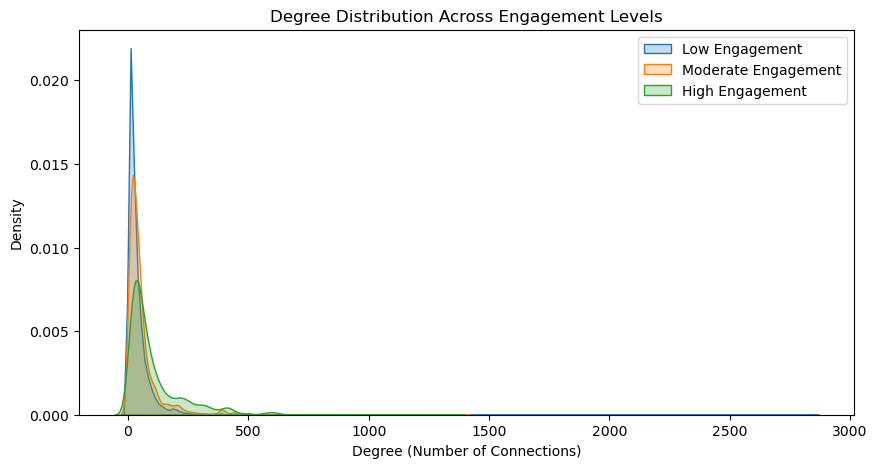

In [63]:
plt.figure(figsize=(10, 5))

for level in ["Low Engagement", "Moderate Engagement", "High Engagement"]:
    subset = df_community[df_community["Engagement_Level"] == level]["Degree"]
    sns.kdeplot(subset, label=level, fill=True, common_norm=False)

plt.title("Degree Distribution Across Engagement Levels")
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Density")
plt.legend()
plt.show()

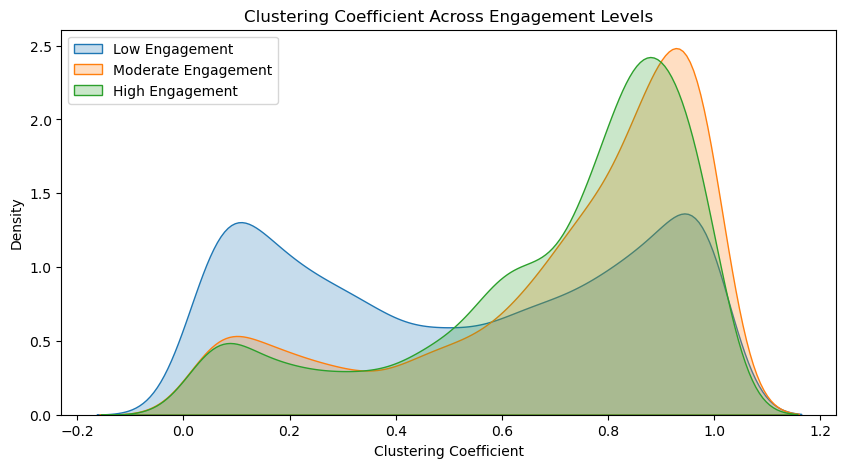

In [64]:
plt.figure(figsize=(10, 5))
for level in ["Low Engagement", "Moderate Engagement", "High Engagement"]:
    sns.kdeplot(df_community[df_community["Engagement_Level"] == level]["Clustering_Coefficient"], label=level, fill=True, common_norm=False)

plt.title("Clustering Coefficient Across Engagement Levels")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Density")
plt.legend()
plt.show()

In [65]:
df_community.groupby("Engagement_Level")["Community_Count"].nunique()

Engagement_Level
High Engagement        16
Low Engagement          1
Moderate Engagement     1
Name: Community_Count, dtype: int64

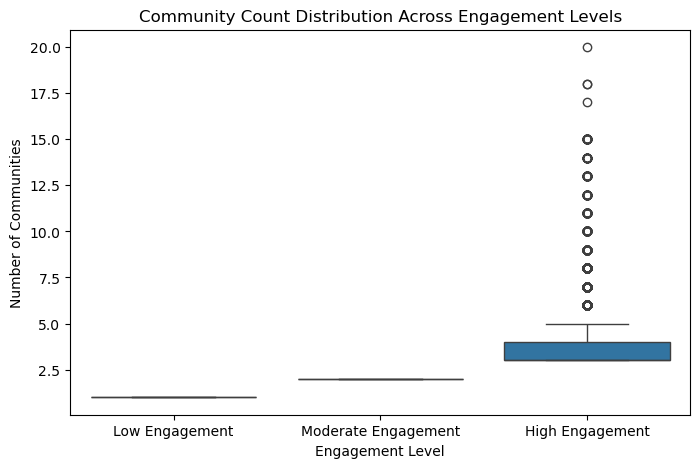

In [66]:
# Boxplot for Community Count per Engagement Level
plt.figure(figsize=(8, 5))
sns.boxplot(x="Engagement_Level", y="Community_Count", data=df_community)
plt.title("Community Count Distribution Across Engagement Levels")
plt.xlabel("Engagement Level")
plt.ylabel("Number of Communities")
plt.show()

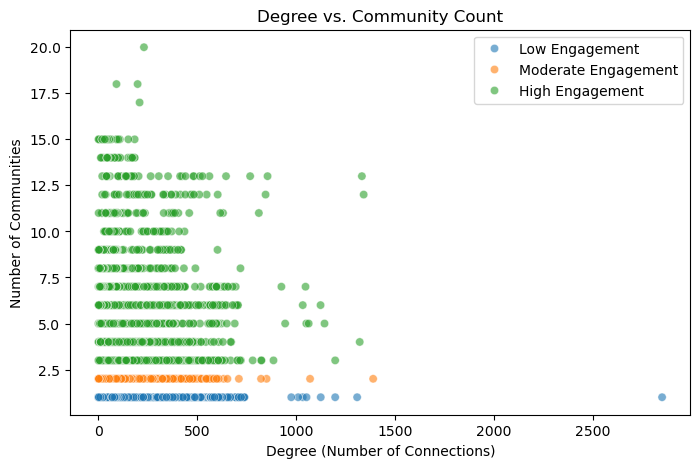

In [67]:
# Scatter plot of Degree vs. Community Count
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Degree", y="Community_Count", hue="Engagement_Level", data=df_community, alpha=0.6)
plt.title("Degree vs. Community Count")
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Number of Communities")
plt.legend()
plt.show()

In [68]:
# Statistical Tests
# 1. Kruskal-Wallis Test for Community Count across Engagement Levels
low = df_community[df_community["Engagement_Level"] == "Low Engagement"]["Community_Count"]
moderate = df_community[df_community["Engagement_Level"] == "Moderate Engagement"]["Community_Count"]
high = df_community[df_community["Engagement_Level"] == "High Engagement"]["Community_Count"]

kw_stat, kw_p = kruskal(low, moderate, high, nan_policy="omit")

# Hypothesis Decision for Kruskal-Wallis
alpha = 0.05
if kw_p < alpha:
    print(f"Kruskal-Wallis Test: H-statistic={kw_stat:.4f}, p-value={kw_p:.4f}")
    print("Result: Reject H0 ‚Üí Community Count significantly differs across Engagement Levels.")
else:
    print(f"Kruskal-Wallis Test: H-statistic={kw_stat:.4f}, p-value={kw_p:.4f}")
    print("Result: Fail to reject H0 ‚Üí No significant difference in Community Count across Engagement Levels.")


# 2. Spearman Correlation between Degree and Community Count
spearman_corr, spearman_p = spearmanr(df_community["Degree"], df_community["Community_Count"], nan_policy="omit")

# Hypothesis Decision for Spearman Correlation
if spearman_p < alpha:
    print(f"Spearman Correlation: rho={spearman_corr:.4f}, p-value={spearman_p:.4f}")
    print("Result: Reject H0 ‚Üí Significant correlation between Degree and Community Count.")
else:
    print(f"Spearman Correlation: rho={spearman_corr:.4f}, p-value={spearman_p:.4f}")
    print("Result: Fail to reject H0 ‚Üí No significant correlation between Degree and Community Count.")

Kruskal-Wallis Test: H-statistic=84218.8886, p-value=0.0000
Result: Reject H0 ‚Üí Community Count significantly differs across Engagement Levels.
Spearman Correlation: rho=0.2998, p-value=0.0000
Result: Reject H0 ‚Üí Significant correlation between Degree and Community Count.


### **RQ5 Analysis Summary**  

#### **Overview**  
To examine how user engagement levels relate to their social connectivity and interactions, we analyzed three key aspects:  

1Ô∏è‚É£ **Degree Distribution** ‚Äì Measuring how many connections users have.  
2Ô∏è‚É£ **Community Count** ‚Äì Identifying how many communities users belong to.  
3Ô∏è‚É£ **Clustering Coefficient** ‚Äì Evaluating how interconnected a user‚Äôs connections are.  

This approach helped us understand the relationship between engagement levels and structural positioning in the network.  

#### **Key Insights**  

**1Ô∏è‚É£ Degree Distribution & Engagement Levels**  
üìå **Observation:**  
- Users with **high engagement** have the highest average degree (107.34), followed by **moderate engagement** (58.17) and **low engagement** (38.79).  
- The median degree follows a similar pattern, indicating a consistent trend.  
- The variance in degree is significantly higher for **high engagement** users, showing that their connectivity varies widely.  

üìå **Interpretation:**  
- Users with **higher engagement** tend to have significantly **more connections**, reinforcing the idea that engagement correlates with network size.  
- The **wide variance** suggests that while some high-engagement users are well-connected, others may still have fewer connections but maintain high engagement through alternative means.  

**2Ô∏è‚É£ Community Count Across Engagement Levels**  
üìå **Observation:**  
- Users with **low engagement** belong to only **one** community on average, with **zero variance** (indicating a strict single-community membership).  
- **Moderate engagement** users belong to **two communities** on average, again with low variance.  
- **High engagement** users belong to **four communities** on average, with significantly higher variance (some users are in as many as 20 communities).  

üìå **Interpretation:**  
- **High engagement users** are **more likely to be part of multiple communities**, suggesting that their interactions extend beyond a single social group.  
- **Low engagement users** are typically **isolated within one community**, potentially limiting their exposure to diverse interactions.  
- This trend indicates that **community participation** is a strong factor in engagement levels.  

**3Ô∏è‚É£ Clustering Coefficient & Social Connectivity**  
üìå **Observation:**  
- Clustering coefficient distributions show a **peak near zero** for all engagement levels, indicating that many users have **low interconnectedness** among their connections.  
- However, **high engagement users** exhibit slightly higher clustering on average, suggesting that their social circles are somewhat more interconnected.  

üìå **Interpretation:**  
- Most users are **not embedded in tightly knit social circles**, regardless of engagement level.  
- However, **high engagement users** exhibit slightly more interconnected friend groups, meaning their relationships may involve **more frequent interactions** within overlapping networks.  
- This finding aligns with the community count insight‚Äîusers with **more communities** may interact in **densely connected subgroups**, increasing engagement opportunities.  

#### **Statistical Tests & Correlations**  

üìå **Kruskal-Wallis Test (Community Count vs. Engagement Levels):**  
- **H-statistic = 84,218.89**, **p-value < 0.0001**  
- **Result:** **Reject H‚ÇÄ** ‚Üí **Community count significantly differs across engagement levels.**  

üìå **Spearman Correlation (Degree vs. Community Count):**  
- **rho = 0.2998**, **p-value < 0.0001**  
- **Result:** **Reject H‚ÇÄ** ‚Üí **Significant positive correlation between degree and community count.**  

**Takeaway:**  
- The **significant difference in community count across engagement levels** confirms that **engagement is strongly tied to participation in multiple communities**.  
- The **positive correlation between degree and community count** shows that **users with more connections tend to belong to more communities**, reinforcing the idea that **high connectivity enables broader social participation**.  

#### **Relevance for TechiesMatch**  

üîπ **Leveraging Multi-Community Users for Matchmaking**  
- Since high engagement users are more likely to belong to multiple communities TechiesMatch can prioritize them as potential social bridges‚Äîhelping expand match pools across different professional or interest-based groups.  

üîπ **Customizing Match Suggestions Based on Social Structure**  
- Users with low engagement and single-community membership may **prefer deeper matches within their existing networks**.  
- **Highly engaged, multi-community users** may be **more open to diverse matches**, allowing TechiesMatch to offer cross-community introductions.  

üîπ **Enhancing Engagement by Encouraging Cross-Community Interaction**  
- TechiesMatch could **incentivize participation in multiple communities**, as **engagement tends to increase with broader social involvement**.  
- Features like **suggested community participation** or **network-based event matching** could encourage users to expand their reach, leading to **higher engagement and better match variety**.  

üîπ **Predicting User Engagement Through Network Structure**  
- Since engagement levels strongly correlate with **degree and community count**, TechiesMatch could use **network-based indicators to predict engagement** and tailor its matchmaking algorithm accordingly.  
- **Users with few connections and single-community membership** could receive **match prompts that encourage more social interaction**, improving their overall experience.  

## **RQ6: New User Integration ‚Äì How Do Newcomers Connect in the LiveJournal Network?**

### üîç **Explanation**  
When new users join an online community, their integration into the network can have a profound effect on both their long-term engagement and the network‚Äôs structure. By analyzing the **LiveJournal dataset**, we seek to understand how newcomers form initial connections‚Äîwhether they tend to connect with highly connected individuals (indicative of **preferential attachment**) or form connections more randomly.

To examine this, we focus on the following:

**1Ô∏è‚É£ Connection Patterns of New Users**
- **Do new users prefer connecting with highly connected individuals (preferential attachment)?**
  This will reveal if newcomers gravitate toward well-established members, likely due to visibility, influence, or shared interests.
- **Do they form connections more randomly?**
  If newcomers connect randomly, it suggests a more organic and dispersed network formation.
- **How does their initial connection choice influence their long-term network position?**
  We will track whether these early choices determine if new users become more central or peripheral in the network over time.

**2Ô∏è‚É£ Growth & Evolution of the Network**
- **How does the addition of new users impact the overall network structure?**
  As new users join, the network‚Äôs topology may shift. This could indicate either more centralization (a few powerful users dominate) or decentralization (more evenly distributed connections).
- **Does the network become more centralized or evenly connected over time?**
  This analysis will help determine if the network tends to consolidate around key individuals or becomes more distributed.

**3Ô∏è‚É£ Retention & Engagement of Newcomers**
- **Are new users who connect to highly engaged members more likely to stay active?**
  By examining if new users who interact with active members engage more, we can infer how early connections impact retention.
- **How does early engagement affect their likelihood of forming strong social ties?**
  Early connections could be key in determining whether newcomers stay engaged and form lasting relationships.

### üîó **TechiesMatch Relevance**
Understanding the patterns of how new users integrate into the LiveJournal network offers valuable insights for **TechiesMatch**:

‚úÖ **Optimized Onboarding** ‚Äì If preferential attachment is dominant, TechiesMatch could strategically introduce new users to influential members, accelerating engagement and providing quicker social integration.

‚úÖ **Reducing Drop-off Rates** ‚Äì If early social connections strongly influence user retention, TechiesMatch could design features that foster early engagement, such as **personalized introductions** or **guided networking events**. These actions would encourage new users to form meaningful ties from the start.

‚úÖ **Balanced Matchmaking** ‚Äì If new users struggle to integrate without proactive matchmaking, TechiesMatch could refine its algorithm to connect them with users who are more likely to help enhance their network cohesion, ensuring better and more sustainable connections.